## Variáveis agregadas (2018 a 2024)


Neste teste será considerada a base de dados completa, sem considerar o pré-processamento dos dados indicado no capítulo "Pré Processamento".

### Bibliotecas e base de dados

In [1]:
# Importar bibliotecas
import pandas as pd
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import metrics
from skopt import BayesSearchCV
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

#Estilizar conteúdo
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

def estilo_tabelas(df, max_altura='300px', casas_decimais=3):
    return (
        df.style.set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '100px')]},
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},  # Bordas cinza escuro
            ]
        ).set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        ).set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'  
        ).format(
            precision=casas_decimais  
        )
    )

# Importar a base de dados

df_eventos_2018_2024_modelo2 = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2018_2024_modelo2.csv",
    sep=';',
    decimal=',',
)

estilo_tabelas(df_eventos_2018_2024_modelo2.head(5))

,Status,DH_MORTOS,DH_FERIDOS,DH_ENFERMOS,DH_DESABRIGADOS,DH_DESALOJADOS,DH_DESAPARECIDOS,DH_OUTROS AFETADOS,DM_Uni Habita Danificadas,DM_Uni Habita Destruidas,DM_Uni Habita Valor,DM_Inst Saúde Danificadas,DM_Inst Saúde Destruidas,DM_Inst Saúde Valor,DM_Inst Ensino Danificadas,DM_Inst Ensino Destruidas,DM_Inst Ensino Valor,DM_Inst Serviços Danificadas,DM_Inst Serviços Destruidas,DM_Inst Serviços Valor,DM_Inst Comuni Danificadas,DM_Inst Comuni Destruidas,DM_Inst Comuni Valor,DM_Obras de Infra Danificadas,DM_Obras de Infra Destruidas,DM_Obras de Infra Valor,PEPL_Assis_méd e emergên(R$),PEPL_Abast de água pot(R$),PEPL_sist de esgotos sanit(R$),PEPL_Sis limp e rec lixo (R$),PEPL_Sis cont pragas (R$),PEPL_distrib energia (R$),PEPL_Telecomunicações (R$),PEPL_Tran loc/reg/l_curso (R$),PEPL_Distrib combustíveis(R$),PEPL_Segurança pública (R$),PEPL_Ensino (R$),PEPR_Agricultura (R$),PEPR_Pecuária (R$),PEPR_Indústria (R$),PEPR_Comércio (R$),PEPR_Serviços (R$),DensidadePop,DOMICILIO_AREARURAL,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,QTDE_FAMILIAS_ATUALIZADAS,Sigla_UF_AC,Sigla_UF_AL,Sigla_UF_AM,Sigla_UF_AP,Sigla_UF_BA,Sigla_UF_CE,Sigla_UF_DF,Sigla_UF_ES,Sigla_UF_GO,Sigla_UF_MA,Sigla_UF_MG,Sigla_UF_MS,Sigla_UF_MT,Sigla_UF_PA,Sigla_UF_PB,Sigla_UF_PE,Sigla_UF_PI,Sigla_UF_PR,Sigla_UF_RJ,Sigla_UF_RN,Sigla_UF_RO,Sigla_UF_RR,Sigla_UF_RS,Sigla_UF_SC,Sigla_UF_SE,Sigla_UF_SP,Sigla_UF_TO,Sigla_UF_pa,COBRADE_11110,COBRADE_11120,COBRADE_11311,COBRADE_11312,COBRADE_11313,COBRADE_11321,COBRADE_11331,COBRADE_11332,COBRADE_11340,COBRADE_11410,COBRADE_11420,COBRADE_11431,COBRADE_11432,COBRADE_11433,COBRADE_12100,COBRADE_12200,COBRADE_12300,COBRADE_13111,COBRADE_13112,COBRADE_13120,COBRADE_13211,COBRADE_13212,COBRADE_13213,COBRADE_13214,COBRADE_13215,COBRADE_13310,COBRADE_13321,COBRADE_13322,COBRADE_14110,COBRADE_14120,COBRADE_14131,COBRADE_14132,COBRADE_14140,COBRADE_15110,COBRADE_15120,COBRADE_15130,COBRADE_15210,COBRADE_15230,COBRADE_22210,COBRADE_22220,COBRADE_23120,COBRADE_24100,COBRADE_24200,COBRADE_25100,COBRADE_25500
0,0,0,0,0,0,0,0,11650,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,132466.926,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,264933.852,309089.494,58874.189,228137.484,0.000,134.493,0.305,0.191,0.559,0.167,0.091,383.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0,0,0,0,0,0,0,2548,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,103709.315,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5905738.840,603420.207,0.000,0.000,0.000,10.669,0.632,0.246,0.456,0.175,0.070,57.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,1,0,180,0,0,156,0,0,112,0,515149.157,0.000,0,0.000,0.000,0,0.000,0,0,0.000,1,0,161904.021,16.000,0.000,1619040.208,161904.021,0.000,0.000,1766225.681,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,0.708,0.691,0.851,0.691,0.576,356.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000

### Ajustes da base de dados

In [2]:
# Remover linhas com dados ausentes

df_eventos_2018_2024_modelo2 = df_eventos_2018_2024_modelo2.dropna()

estilo_tabelas(df_eventos_2018_2024_modelo2.head(5))

,Status,DH_MORTOS,DH_FERIDOS,DH_ENFERMOS,DH_DESABRIGADOS,DH_DESALOJADOS,DH_DESAPARECIDOS,DH_OUTROS AFETADOS,DM_Uni Habita Danificadas,DM_Uni Habita Destruidas,DM_Uni Habita Valor,DM_Inst Saúde Danificadas,DM_Inst Saúde Destruidas,DM_Inst Saúde Valor,DM_Inst Ensino Danificadas,DM_Inst Ensino Destruidas,DM_Inst Ensino Valor,DM_Inst Serviços Danificadas,DM_Inst Serviços Destruidas,DM_Inst Serviços Valor,DM_Inst Comuni Danificadas,DM_Inst Comuni Destruidas,DM_Inst Comuni Valor,DM_Obras de Infra Danificadas,DM_Obras de Infra Destruidas,DM_Obras de Infra Valor,PEPL_Assis_méd e emergên(R$),PEPL_Abast de água pot(R$),PEPL_sist de esgotos sanit(R$),PEPL_Sis limp e rec lixo (R$),PEPL_Sis cont pragas (R$),PEPL_distrib energia (R$),PEPL_Telecomunicações (R$),PEPL_Tran loc/reg/l_curso (R$),PEPL_Distrib combustíveis(R$),PEPL_Segurança pública (R$),PEPL_Ensino (R$),PEPR_Agricultura (R$),PEPR_Pecuária (R$),PEPR_Indústria (R$),PEPR_Comércio (R$),PEPR_Serviços (R$),DensidadePop,DOMICILIO_AREARURAL,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,QTDE_FAMILIAS_ATUALIZADAS,Sigla_UF_AC,Sigla_UF_AL,Sigla_UF_AM,Sigla_UF_AP,Sigla_UF_BA,Sigla_UF_CE,Sigla_UF_DF,Sigla_UF_ES,Sigla_UF_GO,Sigla_UF_MA,Sigla_UF_MG,Sigla_UF_MS,Sigla_UF_MT,Sigla_UF_PA,Sigla_UF_PB,Sigla_UF_PE,Sigla_UF_PI,Sigla_UF_PR,Sigla_UF_RJ,Sigla_UF_RN,Sigla_UF_RO,Sigla_UF_RR,Sigla_UF_RS,Sigla_UF_SC,Sigla_UF_SE,Sigla_UF_SP,Sigla_UF_TO,Sigla_UF_pa,COBRADE_11110,COBRADE_11120,COBRADE_11311,COBRADE_11312,COBRADE_11313,COBRADE_11321,COBRADE_11331,COBRADE_11332,COBRADE_11340,COBRADE_11410,COBRADE_11420,COBRADE_11431,COBRADE_11432,COBRADE_11433,COBRADE_12100,COBRADE_12200,COBRADE_12300,COBRADE_13111,COBRADE_13112,COBRADE_13120,COBRADE_13211,COBRADE_13212,COBRADE_13213,COBRADE_13214,COBRADE_13215,COBRADE_13310,COBRADE_13321,COBRADE_13322,COBRADE_14110,COBRADE_14120,COBRADE_14131,COBRADE_14132,COBRADE_14140,COBRADE_15110,COBRADE_15120,COBRADE_15130,COBRADE_15210,COBRADE_15230,COBRADE_22210,COBRADE_22220,COBRADE_23120,COBRADE_24100,COBRADE_24200,COBRADE_25100,COBRADE_25500
0,0,0,0,0,0,0,0,11650,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,132466.926,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,264933.852,309089.494,58874.189,228137.484,0.000,134.493,0.305,0.191,0.559,0.167,0.091,383.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0,0,0,0,0,0,0,2548,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,103709.315,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5905738.840,603420.207,0.000,0.000,0.000,10.669,0.632,0.246,0.456,0.175,0.070,57.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0,0,0,0,0,0,0,13245,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,286229.997,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1353851.954,0.000,0.000,0.000,0.000,81.646,0.242,0.157,0.187,0.063,0.028,2231.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.

In [3]:
# Balanceamento da variável target

status_counts = df_eventos_2018_2024_modelo2['Status'].value_counts()
print("\nBalanceamento da variável 'Status':")
display(status_counts)


Balanceamento da variável 'Status':


Status
0    7549
1     726
Name: count, dtype: int64

### Modelo sem balanceamento

#### Treino e teste

In [4]:
X_2018_2024_modelo2 = df_eventos_2018_2024_modelo2.drop('Status', axis=1)

y_2018_2024_modelo2 = df_eventos_2018_2024_modelo2['Status']

X_train_2018_2024_modelo2, X_test_2018_2024_modelo2, y_train_2018_2024_modelo2, y_test_2018_2024_modelo2 = train_test_split(X_2018_2024_modelo2, y_2018_2024_modelo2, test_size=0.2, random_state=1, stratify=y_2018_2024_modelo2)

#### Treinamento sem balanceamento

Inicialmente, o modelo foi treinado sem balanceamento e utilizando-se a busca de hiperparâmetros bayesiana com o objetivo de testar os hiperparâmetros. O teste foi feito a partir dos hiperparâmetros sugeridos por Thakur (2020).

In [5]:
# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'xgb__eta': [0.01, 0.015, 0.025, 0.05, 0.1],  # Taxa de aprendizado
    'xgb__gamma': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],  # Redução mínima da perda
    'xgb__max_depth': [3, 5, 7, 9, 12, 15, 17, 25],  # Profundidade da árvore
    'xgb__min_child_weight': [1, 3, 5, 7],  # Peso mínimo para divisão do nó
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subamostragem para treinamento
    'xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subamostragem de colunas
    'xgb__lambda': [0.01, 0.1, 1.0],  # Regularização L2
    'xgb__alpha': [0, 0.1, 0.5, 1.0]  # Regularização L1
}

# Criar pipeline com RobustScaler e XGBoost Classifier
pipeline_xgb = Pipeline([
    ('scaler', RobustScaler()),  # Alterado para RobustScaler
    ('xgb', xgb.XGBClassifier(random_state=1, eval_metric='logloss'))
])

# Realizar a busca bayesiana com validação cruzada
bayes_search_xgb = BayesSearchCV(
    pipeline_xgb,
    search_spaces=param_grid_bayes,
    n_iter=30, 
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=1
)

# Ajustar a busca bayesiana ao conjunto de treino
bayes_search_xgb.fit(X_train_2018_2024_modelo2, y_train_2018_2024_modelo2)

# Melhor modelo encontrado
best_xgb_model = bayes_search_xgb.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {bayes_search_xgb.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_xgb = best_xgb_model.predict(X_test_2018_2024_modelo2)

# Relatório de classificação
classification_report_xgb = metrics.classification_report(y_test_2018_2024_modelo2, y_pred_xgb, digits=6, target_names=['Reconhecido', 'Não reconhecido'])
print('Classification report para XGBoost: \n')
print(classification_report_xgb)

Melhores hiperparâmetros: OrderedDict([('xgb__alpha', 0.1), ('xgb__colsample_bytree', 0.8), ('xgb__eta', 0.1), ('xgb__gamma', 0.9), ('xgb__lambda', 1.0), ('xgb__max_depth', 7), ('xgb__min_child_weight', 1), ('xgb__subsample', 0.9)])
Classification report para XGBoost: 

                 precision    recall  f1-score   support

    Reconhecido   0.939925  0.994702  0.966538      1510
Não reconhecido   0.859649  0.337931  0.485149       145

       accuracy                       0.937160      1655
      macro avg   0.899787  0.666317  0.725843      1655
   weighted avg   0.932892  0.937160  0.924362      1655



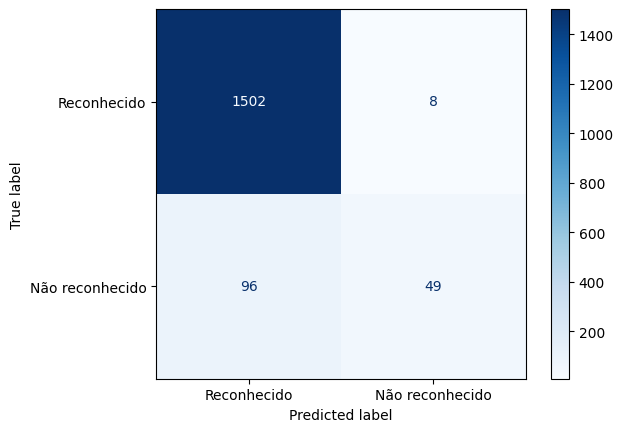

In [6]:
ConfusionMatrixDisplay.from_estimator(best_xgb_model, X_test_2018_2024_modelo2, y_test_2018_2024_modelo2, values_format='d', cmap='Blues', display_labels=['Reconhecido', 'Não reconhecido'])

### Modelo com balanceamento SMOTE

Treinamento do modelo com balanceamento SMOTE e utilizando-se a busca de hiperparâmetros bayesiana com o objetivo de testar os hiperparâmetros. O teste foi feito a partir dos hiperparâmetros sugeridos por Thakur (2020).

#### Treino e teste

In [7]:
X_smote = df_eventos_2018_2024_modelo2.drop('Status', axis=1)

y_smote = df_eventos_2018_2024_modelo2['Status']

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.2, random_state=1, stratify=y_smote)

#### Treinamento com balanceamento SMOTE

In [8]:
# Aplicar SMOTE apenas no conjunto de treino
smote = SMOTE(random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train_smote, y_train_smote)

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'xgb__eta': [0.01, 0.015, 0.025, 0.05, 0.1],
    'xgb__gamma': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'xgb__max_depth': [3, 5, 7, 9, 12, 15, 17, 25],
    'xgb__min_child_weight': [1, 3, 5, 7],
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'xgb__lambda': [0.01, 0.1, 1.0],
    'xgb__alpha': [0, 0.1, 0.5, 1.0]
}

# Criar pipeline com RobustScaler e XGBoost Classifier
pipeline_xgb_smote = Pipeline([
    ('scaler', RobustScaler()),  # Usando RobustScaler
    ('xgb', xgb.XGBClassifier(random_state=1, eval_metric='logloss'))
])

# Realizar a busca bayesiana com validação cruzada no conjunto balanceado pelo SMOTE
bayes_search_xgb_smote = BayesSearchCV(
    pipeline_xgb_smote,
    search_spaces=param_grid_bayes,
    n_iter=30,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=1
)

# Ajustar o modelo ao conjunto de treino balanceado
bayes_search_xgb_smote.fit(X_train_smote, y_train_smote)

# Melhor modelo encontrado
best_xgb_model_smote = bayes_search_xgb_smote.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros com balanceamento smote: {bayes_search_xgb_smote.best_params_}")

# Fazer previsões com o conjunto de teste original
y_pred_xgb_smote = best_xgb_model_smote.predict(X_test_smote)

# Relatório de classificação
classification_report_xgb_smote = metrics.classification_report(
    y_test_smote, y_pred_xgb_smote, digits=6, target_names=['Reconhecido', 'Não reconhecido']
)

print('Classification report para XGBoost com SMOTE: \n')
print(classification_report_xgb_smote)

Melhores hiperparâmetros com balanceamento smote: OrderedDict([('xgb__alpha', 0.1), ('xgb__colsample_bytree', 0.6), ('xgb__eta', 0.1), ('xgb__gamma', 0.05), ('xgb__lambda', 0.1), ('xgb__max_depth', 17), ('xgb__min_child_weight', 1), ('xgb__subsample', 0.9)])
Classification report para XGBoost com SMOTE: 

                 precision    recall  f1-score   support

    Reconhecido   0.943707  0.988079  0.965383      1510
Não reconhecido   0.756757  0.386207  0.511416       145

       accuracy                       0.935347      1655
      macro avg   0.850232  0.687143  0.738399      1655
   weighted avg   0.927327  0.935347  0.925610      1655



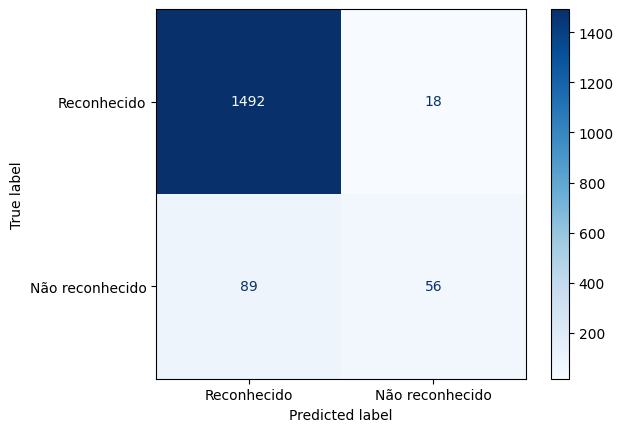

In [9]:
ConfusionMatrixDisplay.from_estimator(bayes_search_xgb_smote, X_test_smote, y_test_smote, 
                                      values_format='d', cmap='Blues', display_labels=['Reconhecido', 'Não reconhecido'])

### Avaliação das Variáveis de Importância

Avaliação das variáveis de importância de acordo com o modelo com Smote, que apresentou o maior f1-score.

#### Feature importance

In [10]:
# Ajustar o melhor modelo encontrado (depois da busca bayesiana)
best_xgb_model_smote.named_steps['xgb'].fit(X_train_smote, y_train_smote)

# Obter o booster (árvores) do modelo treinado
booster = best_xgb_model_smote.named_steps['xgb'].get_booster()

# Obter a importância das features com base no ganho
importance_dict = booster.get_score(importance_type='gain')

# Transformar em DataFrame para organizar como tabela
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
})

# Ordenar pela importância em ordem decrescente
importance_df = importance_df.sort_values(by='Importance', ascending=False)

estilo_tabelas(importance_df)

,Feature,Importance
84,COBRADE_14120,28.563
69,Sigla_UF_SC,27.885
80,COBRADE_13214,25.829
57,Sigla_UF_MS,21.176
10,DM_Inst Saúde Destruidas,19.794
89,COBRADE_22220,16.950
85,COBRADE_14131,16.555
50,Sigla_UF_AP,16.371
86,COBRADE_14132,16.070
81,COBRADE_13215,15.680


#### Permutation importance

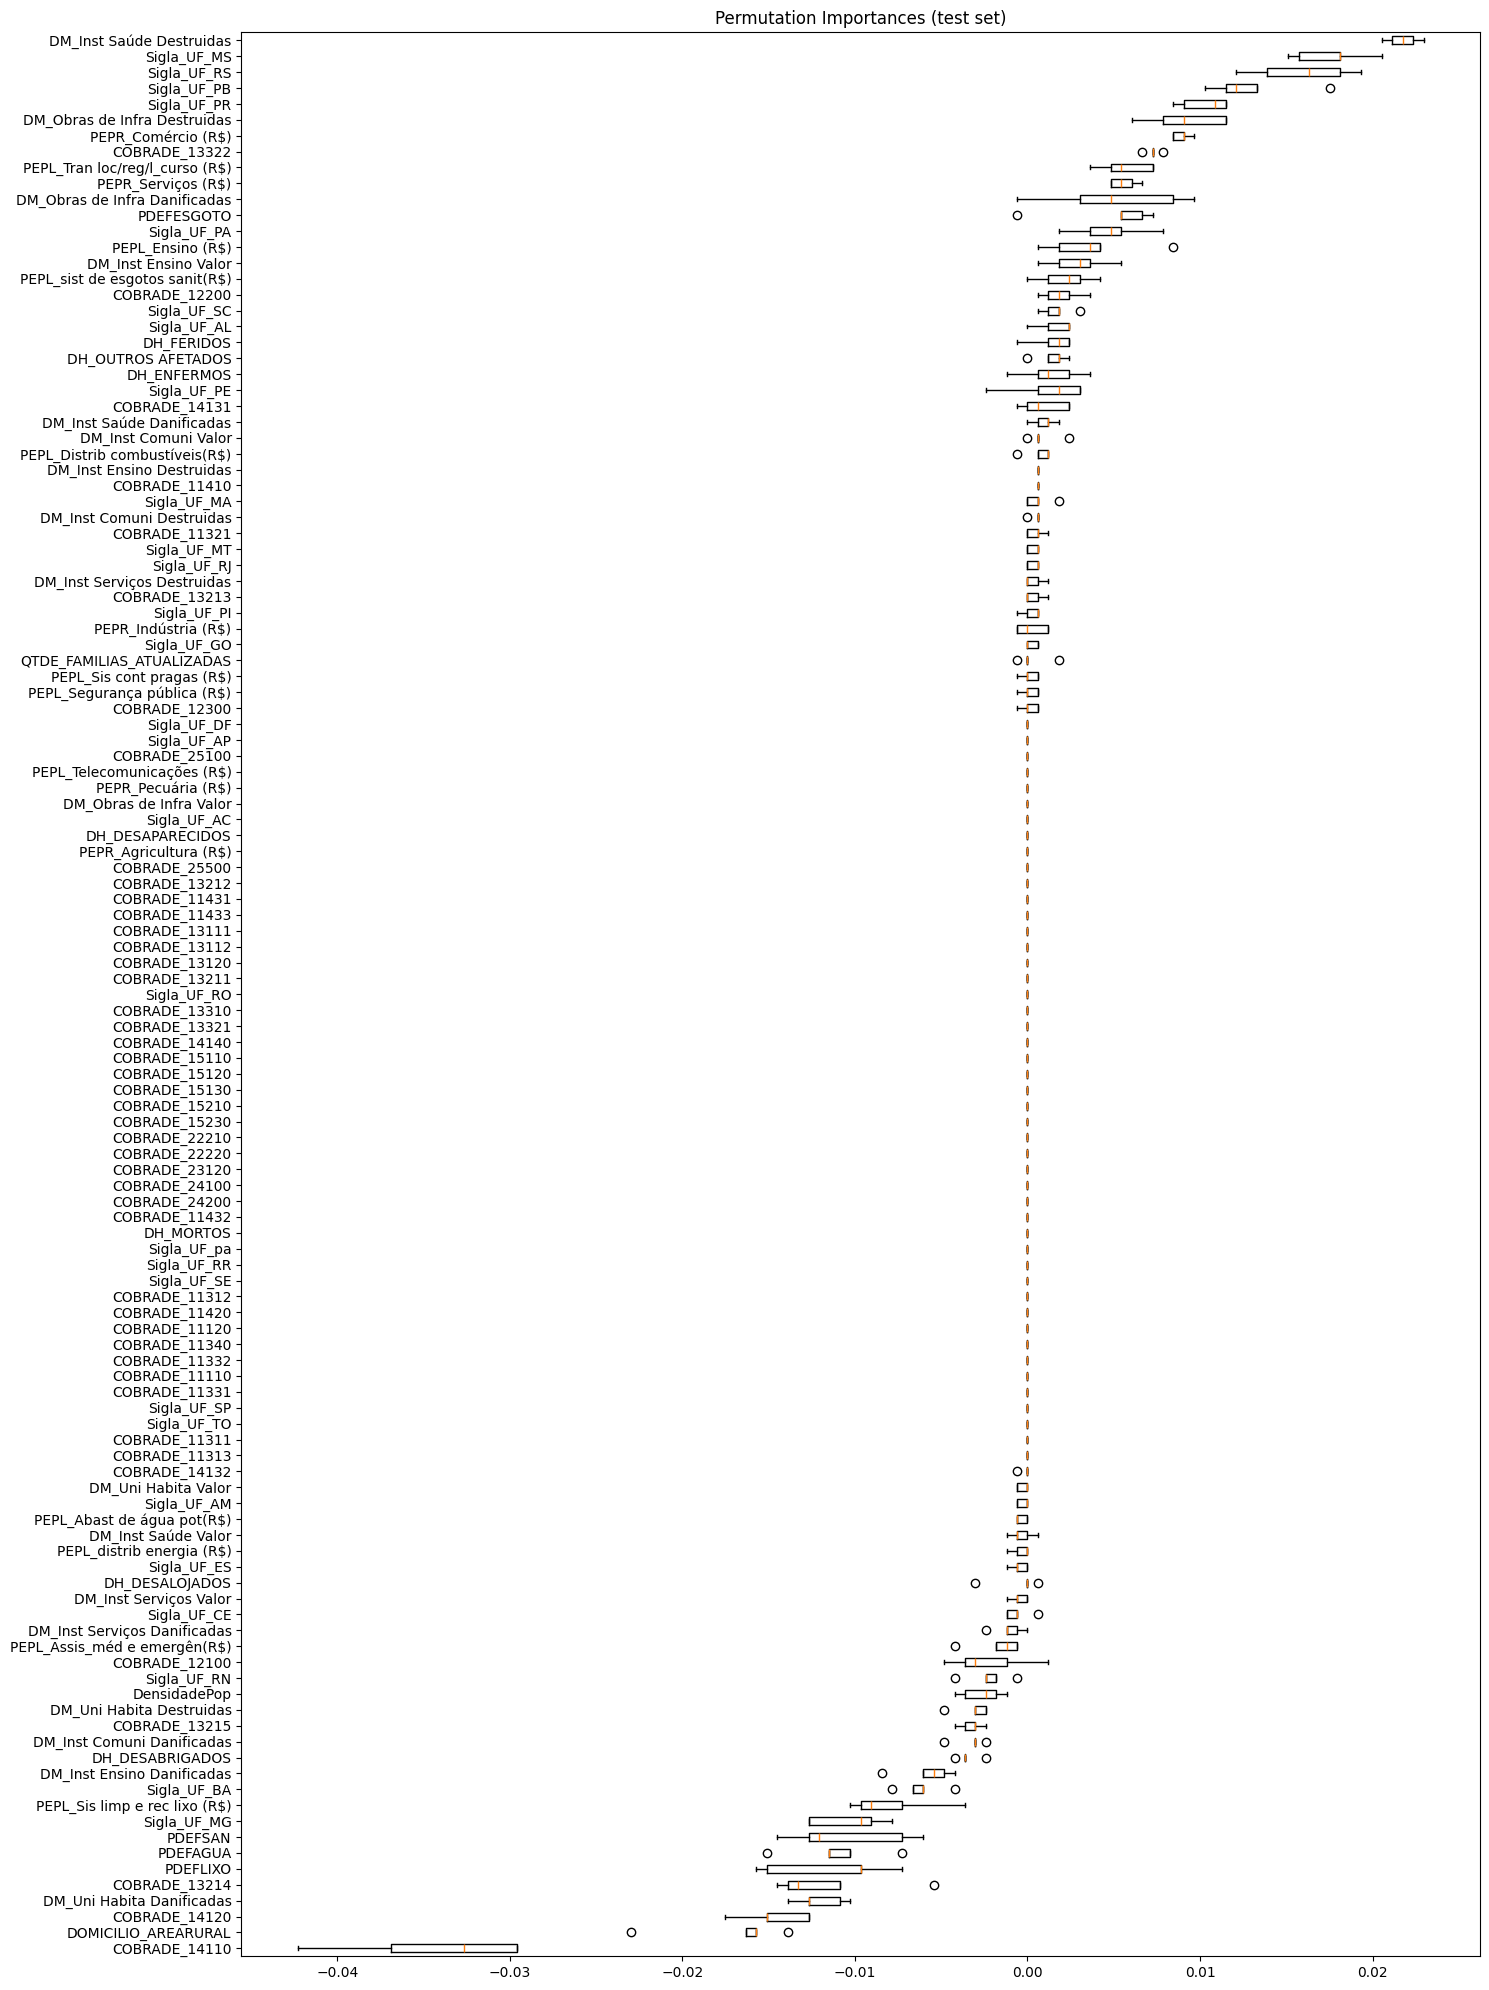

In [11]:
# Calcular a permutação de importância no conjunto de teste
result = permutation_importance(best_xgb_model_smote, X_test_smote, y_test_smote, n_repeats=5, random_state=1, n_jobs=-1)

# Ordenar os resultados pela importância média
sorted_idx = result.importances_mean.argsort()

# Gráfico boxplot para mostrar a importância das variáveis
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, tick_labels=X_test_smote.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.set_size_inches(15, 20) 
fig.tight_layout()
plt.show()

### Modelos com seleção de variáveis

#### Importância média > 0

In [12]:
# Filtrar as variáveis com importância média > 0
positive_idx = result.importances_mean > 0

# Selecionar apenas as colunas das features com importância positiva
selected_features = X_test_smote.columns[positive_idx]

# Criar novos datasets apenas com essas features
X_train_selected = X_train_smote[selected_features]
X_test_selected = X_test_smote[selected_features]

# Exibir as features selecionadas
print("Features selecionadas:", selected_features.tolist())

Features selecionadas: ['DH_FERIDOS', 'DH_ENFERMOS', 'DH_OUTROS AFETADOS', 'DM_Inst Saúde Danificadas', 'DM_Inst Saúde Destruidas', 'DM_Inst Ensino Destruidas', 'DM_Inst Ensino Valor', 'DM_Inst Serviços Destruidas', 'DM_Inst Comuni Destruidas', 'DM_Inst Comuni Valor', 'DM_Obras de Infra Danificadas', 'DM_Obras de Infra Destruidas', 'PEPL_sist de esgotos sanit(R$)', 'PEPL_Sis cont pragas (R$)', 'PEPL_Tran loc/reg/l_curso (R$)', 'PEPL_Distrib combustíveis(R$)', 'PEPL_Segurança pública (R$)', 'PEPL_Ensino (R$)', 'PEPR_Indústria (R$)', 'PEPR_Comércio (R$)', 'PEPR_Serviços (R$)', 'PDEFESGOTO', 'QTDE_FAMILIAS_ATUALIZADAS', 'Sigla_UF_AL', 'Sigla_UF_GO', 'Sigla_UF_MA', 'Sigla_UF_MS', 'Sigla_UF_MT', 'Sigla_UF_PA', 'Sigla_UF_PB', 'Sigla_UF_PE', 'Sigla_UF_PI', 'Sigla_UF_PR', 'Sigla_UF_RJ', 'Sigla_UF_RS', 'Sigla_UF_SC', 'COBRADE_11321', 'COBRADE_11410', 'COBRADE_12200', 'COBRADE_12300', 'COBRADE_13213', 'COBRADE_13322', 'COBRADE_14131']


In [13]:
# Aplicar SMOTE apenas no conjunto de treino com as variáveis selecionadas.
smote = SMOTE(random_state=1)
X_train_selected, y_train_smote = smote.fit_resample(X_train_selected, y_train_smote)

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'xgb__eta': [0.01, 0.015, 0.025, 0.05, 0.1],
    'xgb__gamma': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'xgb__max_depth': [3, 5, 7, 9, 12, 15, 17, 25],
    'xgb__min_child_weight': [1, 3, 5, 7],
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'xgb__lambda': [0.01, 0.1, 1.0],
    'xgb__alpha': [0, 0.1, 0.5, 1.0]
}

# Criar pipeline com RobustScaler e XGBoost Classifier
pipeline_xgb_smote = Pipeline([
    ('scaler', RobustScaler()),  # Usando RobustScaler
    ('xgb', xgb.XGBClassifier(random_state=1, eval_metric='logloss'))
])

# Realizar a busca bayesiana com validação cruzada no conjunto balanceado pelo SMOTE
bayes_search_xgb_smote = BayesSearchCV(
    pipeline_xgb_smote,
    search_spaces=param_grid_bayes,
    n_iter=30,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=1
)

# Ajustar o modelo ao conjunto de treino balanceado
bayes_search_xgb_smote.fit(X_train_selected, y_train_smote)

# Melhor modelo encontrado
best_xgb_model_smote = bayes_search_xgb_smote.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros com balanceamento smote: {bayes_search_xgb_smote.best_params_}")

# Fazer previsões com o conjunto de teste original
y_pred_xgb_smote = best_xgb_model_smote.predict(X_test_selected)

# Relatório de classificação
classification_report_xgb_smote = metrics.classification_report(
    y_test_smote, y_pred_xgb_smote, digits=6, target_names=['Reconhecido', 'Não reconhecido']
)

print('Classification report para XGBoost com SMOTE e considerando apenas variáveis com importância média positiva: \n')
print(classification_report_xgb_smote)

Melhores hiperparâmetros com balanceamento smote: OrderedDict([('xgb__alpha', 0), ('xgb__colsample_bytree', 0.9), ('xgb__eta', 0.05), ('xgb__gamma', 0.1), ('xgb__lambda', 0.1), ('xgb__max_depth', 25), ('xgb__min_child_weight', 1), ('xgb__subsample', 0.7)])
Classification report para XGBoost com SMOTE e considerando apenas variáveis com importância média positiva: 

                 precision    recall  f1-score   support

    Reconhecido   0.944733  0.962252  0.953412      1510
Não reconhecido   0.512821  0.413793  0.458015       145

       accuracy                       0.914199      1655
      macro avg   0.728777  0.688022  0.705714      1655
   weighted avg   0.906892  0.914199  0.910009      1655



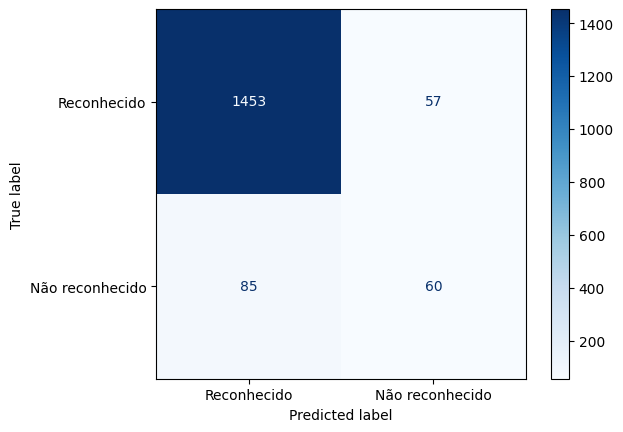

In [14]:
ConfusionMatrixDisplay.from_estimator(bayes_search_xgb_smote, X_test_selected, y_test_smote, 
                                      values_format='d', cmap='Blues', display_labels=['Reconhecido', 'Não reconhecido'])

#### Importância média > -0.01

In [15]:
# Ajustando o threshold para manter variáveis com importância > -0.01
positive_idx_adjusted = result.importances_mean > -0.01

# Selecionar apenas as colunas das features com importância ajustada
selected_features_adjusted = X_test_smote.columns[positive_idx_adjusted]

# Criar novos datasets apenas com essas features
X_train_selected_adjusted = X_train_smote[selected_features_adjusted]
X_test_selected_adjusted = X_test_smote[selected_features_adjusted]

# Aplicar SMOTE apenas no conjunto de treino com as variáveis selecionadas.
smote = SMOTE(random_state=1)
X_train_selected_adjusted, y_train_smote = smote.fit_resample(X_train_selected_adjusted, y_train_smote)

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'xgb__eta': [0.01, 0.015, 0.025, 0.05, 0.1],
    'xgb__gamma': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'xgb__max_depth': [3, 5, 7, 9, 12, 15, 17, 25],
    'xgb__min_child_weight': [1, 3, 5, 7],
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'xgb__lambda': [0.01, 0.1, 1.0],
    'xgb__alpha': [0, 0.1, 0.5, 1.0]
}

# Criar pipeline com RobustScaler e XGBoost Classifier
pipeline_xgb_smote = Pipeline([
    ('scaler', RobustScaler()),  # Usando RobustScaler
    ('xgb', xgb.XGBClassifier(random_state=1, eval_metric='logloss'))
])

# Realizar a busca bayesiana com validação cruzada no conjunto balanceado pelo SMOTE
bayes_search_xgb_smote = BayesSearchCV(
    pipeline_xgb_smote,
    search_spaces=param_grid_bayes,
    n_iter=30,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=1
)

# Ajustar o modelo ao conjunto de treino balanceado
bayes_search_xgb_smote.fit(X_train_selected_adjusted, y_train_smote)

# Melhor modelo encontrado
best_xgb_model_smote = bayes_search_xgb_smote.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros com balanceamento smote: {bayes_search_xgb_smote.best_params_}")

# Fazer previsões com o conjunto de teste original
y_pred_xgb_smote = best_xgb_model_smote.predict(X_test_selected_adjusted)

# Relatório de classificação
classification_report_xgb_smote = metrics.classification_report(
    y_test_smote, y_pred_xgb_smote, digits=6, target_names=['Reconhecido', 'Não reconhecido']
)

print('Classification report para XGBoost com SMOTE e considerando apenas variáveis com importância média > -0.01: \n')
print(classification_report_xgb_smote)


Melhores hiperparâmetros com balanceamento smote: OrderedDict([('xgb__alpha', 0), ('xgb__colsample_bytree', 0.7), ('xgb__eta', 0.1), ('xgb__gamma', 0.05), ('xgb__lambda', 0.1), ('xgb__max_depth', 25), ('xgb__min_child_weight', 1), ('xgb__subsample', 0.9)])
Classification report para XGBoost com SMOTE e considerando apenas variáveis com importância média > -0.01: 

                 precision    recall  f1-score   support

    Reconhecido   0.946863  0.979470  0.962891      1510
Não reconhecido   0.666667  0.427586  0.521008       145

       accuracy                       0.931118      1655
      macro avg   0.806765  0.703528  0.741950      1655
   weighted avg   0.922314  0.931118  0.924176      1655



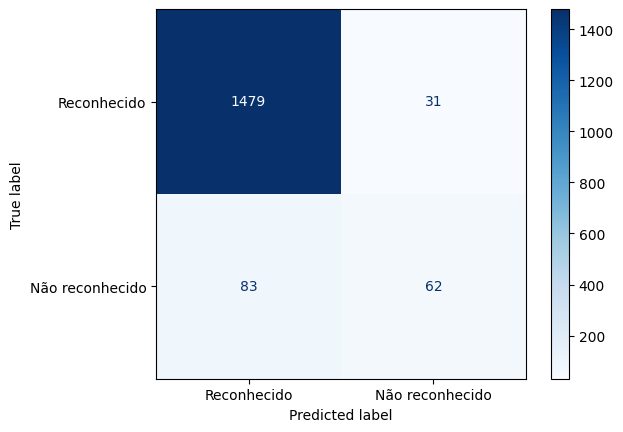

In [16]:
ConfusionMatrixDisplay.from_estimator(bayes_search_xgb_smote, X_test_selected_adjusted, y_test_smote, 
                                      values_format='d', cmap='Blues', display_labels=['Reconhecido', 'Não reconhecido'])

#### Correlação < 0.5

In [17]:
import pandas as pd
import numpy as np

# Calcular a matriz de correlação
corr_matrix = X_train_smote.corr()

# Criar um dataframe para armazenar os pares com alta correlação
high_corr_pairs = set()

# Iterar pela matriz de correlação e encontrar pares com correlação acima de 0.5
threshold = 0.5
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            # Adicionar os pares de features com correlação maior que o threshold
            high_corr_pairs.add((corr_matrix.columns[i], corr_matrix.columns[j]))

# Exibir os pares com alta correlação
print(f"Pares de features com correlação maior que {threshold}:")
print(high_corr_pairs)

# Remover uma feature de cada par com alta correlação
features_to_remove = {pair[1] for pair in high_corr_pairs}  # Remover a segunda feature em cada par
X_train_uncorrelated = X_train_smote.drop(columns=features_to_remove)
X_test_uncorrelated = X_test_smote.drop(columns=features_to_remove)

# Exibir as features que foram removidas
print(f"Features removidas devido à alta correlação: {features_to_remove}")


Pares de features com correlação maior que 0.5:
{('DM_Inst Saúde Valor', 'DH_DESALOJADOS'), ('PDEFAGUA', 'DOMICILIO_AREARURAL'), ('PEPL_Sis cont pragas (R$)', 'DM_Inst Serviços Valor'), ('PEPL_Segurança pública (R$)', 'DM_Inst Saúde Valor'), ('PEPR_Indústria (R$)', 'DH_DESALOJADOS'), ('PEPL_Sis cont pragas (R$)', 'DM_Inst Ensino Valor'), ('PEPR_Indústria (R$)', 'DH_MORTOS'), ('PEPL_distrib energia (R$)', 'PEPL_Sis cont pragas (R$)'), ('PEPL_Telecomunicações (R$)', 'PEPL_distrib energia (R$)'), ('PEPL_Telecomunicações (R$)', 'DH_DESALOJADOS'), ('PEPL_Tran loc/reg/l_curso (R$)', 'DM_Uni Habita Valor'), ('PEPL_Tran loc/reg/l_curso (R$)', 'PEPL_Sis cont pragas (R$)'), ('PEPL_sist de esgotos sanit(R$)', 'DH_DESALOJADOS'), ('DM_Inst Serviços Valor', 'DM_Inst Ensino Valor'), ('PEPL_distrib energia (R$)', 'DM_Inst Serviços Valor'), ('DM_Inst Ensino Valor', 'DH_DESALOJADOS'), ('PEPL_Segurança pública (R$)', 'DM_Uni Habita Valor'), ('DM_Inst Ensino Valor', 'DM_Inst Saúde Valor'), ('PEPL_distrib 

In [18]:
# Aplicar o mesmo processo de SMOTE e ajuste do modelo com os dados sem alta correlação
smote = SMOTE(random_state=1)
X_train_uncorrelated_smote, y_train_smote_uncorrelated = smote.fit_resample(X_train_uncorrelated, y_train_smote)

# Ajustar o modelo com os dados sem alta correlação
best_xgb_model_uncorrelated = bayes_search_xgb_smote.fit(X_train_uncorrelated_smote, y_train_smote_uncorrelated)

# Fazer previsões
y_pred_uncorrelated = best_xgb_model_uncorrelated.predict(X_test_uncorrelated)

# Avaliar o desempenho
classification_report_uncorrelated = metrics.classification_report(
    y_test_smote, y_pred_uncorrelated, digits=6, target_names=['Reconhecido', 'Não reconhecido']
)

print('Relatório de classificação após remoção de alta correlação: \n')
print(classification_report_uncorrelated)

Relatório de classificação após remoção de alta correlação: 

                 precision    recall  f1-score   support

    Reconhecido   0.946326  0.980795  0.963252      1510
Não reconhecido   0.677778  0.420690  0.519149       145

       accuracy                       0.931722      1655
      macro avg   0.812052  0.700742  0.741200      1655
   weighted avg   0.922797  0.931722  0.924343      1655



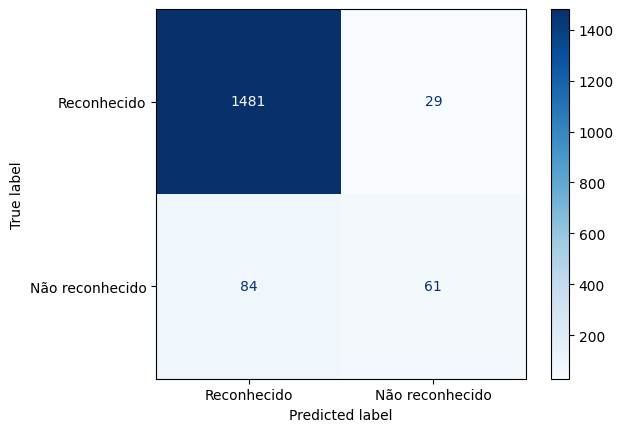

In [19]:
ConfusionMatrixDisplay.from_estimator(bayes_search_xgb_smote, X_test_uncorrelated, y_test_smote, 
                                      values_format='d', cmap='Blues', display_labels=['Reconhecido', 'Não reconhecido'])